# Ch6 Decision Tree

**결정트리(decision tree)**<br>
- 분류, 회귀 작업, 다중출력 작업 가능한 다재다능한 머신러닝 알고리즘
- 매우 복잡한 데이터셋도 학습할 수 있는 강력한 알고리즘
- 랜덤 포레스트의 기본 구성 요소

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 6.1 결정 트리 학습과 시각화

붓꽃 데이터셋(Ch4)에 DecisionTreeClassifier 훈련시키는 코드

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

local에 설치한 graphviz에 오류 발생하여 conda로 재설치

In [6]:
conda install graphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/cha/miniforge3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.07.19 |       hca03da5_0         124 KB
    cairo-1.16.0               |       h29d4eff_2         941 KB
    certifi-2022.6.15          |   py39hca03da5_0         153 KB
    conda-4.14.0               |   py39hca03da5_0         925 KB
    cytoolz-0.11.0             |   py39h1a28f6b_0         301 KB
    expat-2.4.4                |       hc377ac9_0         125 KB
    font-ttf-dejavu-sans-mono-2.37|       hd3eb1b0_0         335 KB
    font-ttf-inconsolata-2.001 |       hcb22688_0          83 KB
    font-ttf-source-code-p

export_graphviz(): 그래프 정의를 iris_tree.dot 파일로 출력하여 결정트리 시각화

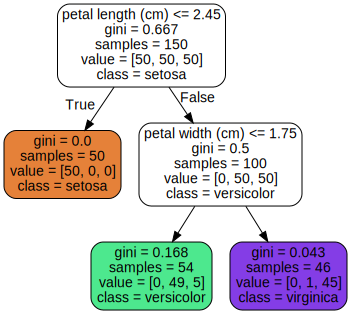

In [7]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join("iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join("iris_tree.dot"))

.dot 파일을 Graphviz 패키지에 있는 dot 명령줄 도구로 pdf 또는 png 포맷으로 변경


$ dot -Tpng iris_tree.dot -o iris_tree.png <br>
=> 이는 .dot 파일을 .png로 바꾸는 것.

## 6.2 예측하기

루트 노드(root node): 깊이가 0인 맨 꼭대기의 노드<br>
리프 노드(leaf node): 자식 노드를 가지지 않는 노드

decision tree의 장점 중 하나<br>
: 데이터 전처리가 거의 필요하지 않음. 특성의 스케일을 맞추거나 평균을 원점에 맞추는 작업이 필요하지 않음.

- 노드의 sample 속성: 얼마나 많은 훈련 샘플이 적용되었는지 헤아린 것.<br>
- 노드의 value 속성: 노드에서 각 클래스에 얼마나 많은 훈련 샘플이 있는지 알려줌.
- 노드의 gini 속성: 불순도(impurity) 측정

**불순도**<br>
한 노드의 모든 샘플이 같은 클래스에 속해 있다면 이 노드를 순수하다하고 이때 gini=0<br>

지니 불순도<br>
$G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}$<br>
이 식에서 $p_{i,k}$는 $i$번째 노드에 있는 훈련 샘플 중 클래스 $k$에 속한 샘플의 비율

사이킷런은 이진트리만 만드는 CART 알고리즘 사용<br>
그러므로 리프 노드 외의 모든 노드는 자식 노드를 두 개씩 가짐.

cf) 모델 해석: 화이트박스와 블랙박스<br>
화이트박스 모델: 직관적이고 결정 방식을 이해하기 쉬운 모델 (eg. 결정트리)<br>
블랙박스 모델: 성능이 뛰어나고 예측을 만드는 연산 과정을 쉽게 확인할 수 있지만 예측을 만드는 것에 대해 설명하기 어려운 모델 (eg. 랜덤포레스트, 신경망)

## 6.3 클래스 확률 추정

결정트리는 한 샘플이 특정 클래스 $k$에 속할 확률 추정 가능

In [11]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [12]:
tree_clf.predict([[5, 1.5]])

array([1])

## 6.4 CART 훈련 알고리즘

**CART**(Classification And Regression Tree) **알고리즘**: 사이킷런에서 결정트리를 훈련시키기 위해 사용

1. 훈련 세트를 하나의 특성 $k$의 임곗값 $t_k$를 사용해 두 개의 서브셋으로 나눈다.
2. (크기에 따른 가중치가 적용된) 가장 순수한 서브셋으로 나눌 수 있는 ($k, t_k$) 짝을 찾는다.

이 알고리즘이 최소화해야하는 비용 함수는 다음과 같다.

분류에 대한 CART 비용 함수

$\begin{split}&J(k,t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\&
\text{여기서}\begin{cases} G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도} \\m_\text{left/right}\text{는 왼쪽/오른쪽 서브셋의 샘플수}\end{cases}\end{split}$

3. CART 알고리즘이 훈련 세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 또 나누고 그 다음엔 서브셋의 서브셋을 나누고를 반복한다.<br>
   이 과정은 최대 깊이가 되면 중지하거나 불순도를 중리는 분할을 찾을 수 없을 때 멈춘다.

cf) 중지 조건에 관여하는 매개변수: max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes

**CAUTION**) CART 알고리즘은 greedy algorithm<br>
맨 위 루트 노드에서 최적의 분할을 찾으며 이어지는 각 단계에서 해당 과정을 반복.<br>
현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도로 이어질 수 있을지 없을지는 고려하지 않음.<br>
이와 같이 그리디 알고리즘은 종종 납득할만한 훌륭한 솔루션을 찾아내지만 최적의 솔루션을 보장하지는 않음. cf) 최적의 트리를 찾는 것은 NP-완전 문제

## 6.5 계산 복잡도

예측을 하기 위해서는 결정 트리를 루트 노드에서부터 리프 노드까지 탐색해야함.<br>
일반적으로 결정 트리는 거의 균형을 이루고 있으므로 결정 트리를 탐색하기 위해서는 약 $O(log_2 (m))$개의 노드를 거쳐야함.

각 노드는 하나의 특성값만을 확인하기 때문에 예측에 필요한 전체 복잡도는 특성 수와 무관하게 $O(log_2 (m))$ <br>
=> 따라서 큰 훈련 세트를 다룰 때도 예측 속도가 매우 빠름.

훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 특성을 비교함 -> 훈련 복잡도: $O(n \times m log_2(m))$<br>
훈련 세트가 작을수록 훈련 속도가 높음.

## 6.6 지니 불순도 또는 엔트로피?

엔트로피 불순도: criterion 매개변수를 "entropy"로 지정한 불순도<br>
cf) 엔트로피: 분자의 무질서함을 측정하는 것으로 분자가 안정되고 질서 정연하면 0에 가까움.<br>
&nbsp; &nbsp; &nbsp; => 어떤 세트가 한 클래스의 샘플만 담고 있으면 엔트로피가 0

엔트로피<br>
$H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}$

**지니 불순도 vs 엔트로피** <br>
지니 불순도가 조금 더 계산이 빠르기 때문에 기본값으로 좋음.<br>
그러나 다른 트리가 만들어지는 경우 지니 불순도가 가장 빈도 높은 클래스 한쪽 가지로 고립시키는 경향이 있는 반면 엔트로피는 좀 더 균형 잡힌 트리를 만듦.

## 6.7 규제 매개변수

**결정 트리**는 훈련되기 전에 파라미터 수가 결정되지 않기 때문에 **비파라미터 모델(nonparametric model)**이라 부름.<br>
이로 인해 모델 구조가 데이터에 맞춰져서 고정되지 않고 자유로움.<br>
훈련 데이터에 대한 제약 사항이 없어 대부분 과대적합되기 쉬움.
반면 선형 모델은 미리 정의된 모델 파라미터 수를 가지므로 파라미터 모델(parametric model), 자유도가 제한되고 과대적합될 위험이 줄어듦.(하지만 과소적합 위험은 커짐)

규제: 훈련 데이터에 대한 과대적합을 피하기 위해 학습할 때 결정 트리의 자유도를 제한하는 것

**결정 트리에서 규제 매개변수**
- max_depth: 결정 트리의 최대 깊이 (기본값은 제한이 없다는 의미인 None)<br>
  이를 줄이면 모델을 규제하게 되고 과대적합의 위험이 감소

DecisionTreeClassifier에서 결정 트리의 형태를 제한하는 다른 매개변수
- min_samples_split: 분할되기 위해 노드가 가져야 하는 최소 샘플 수
- min_samples_leaf: 리프노드가 가지고 있어야 할 최소 샘플 수
- min_weight_fraction_leaf: (min_samples_leaf와 같지만) 가중치가 부여된 전체 샘플 수에서의 비율
- max_leaf_nodes: 리프노드의 최대 수
- max_features: 각 노드에서 분할에 사용할 특성의 최대 수 <br>

=> min으로 시작하는 매개변수를 증가시키거나 max로 시작하는 매개변수를 감소시키면 모델의 규제가 커짐

cf) 제한 없이 결정 트리를 훈련시키고 불필요한 노드를 가지치기(pruning)하는 알고리즘도 존재

## 6.8 회귀

In [13]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

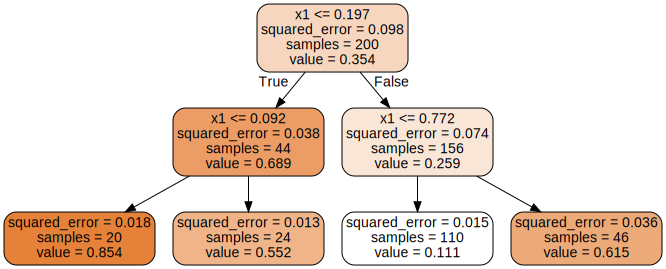

In [18]:
export_graphviz(
        tree_reg,
        out_file=os.path.join("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
)

Source.from_file(os.path.join("regression_tree.dot"))

분류 트리와 비교했을 때의 차이점: 각 노드에서 클래스를 예측하는 대신 어떤 값을 예측한다는 점.<br>
예를 들어  $x1$=0.6 에 대한 타깃값을 예측한다고 해보자. 이 샘플은 결국 value=0.111인 리프노드에 도달. 이 노드에 있는 110개 샘플의 평균 타깃값이 예측값이 됨.<br> => 이 예측값에 대한 MSE: 0.015


각 영역의 예측값은 항상 그 영역에 있는 타깃값의 평균이 됨.<br>
알고리즘은 예측값과 가능한 한 많은 샘플이 가까이 있도록 영역을 분할.

CART 알고리즘은 훈련 세트를 불순도 최소화하는 방향으로 분할하는 대신 MSE를 최소화하도록 분할함.

회귀를 위한 CART 비용 함수<br>
$ \begin{split} &J(k, t_k) = \dfrac{m_{\text{left}}}{m}MSE_\text{left} + \dfrac{m_{\text{right}}}{m}MSE_{\text{right}}\\ &\text{여기서 }\begin{cases} MSE_\text{node} = \displaystyle\sum_{i\in \text{node}}{(\hat{y}_\text{node}-y^{(i)})^2}\\ \hat{y}_\text{node}= \dfrac{1}{m_\text{node}} \displaystyle\sum_{i\in \text{node}}y^{(i)} \end{cases} \end{split} $

분류에서와 같이 회귀 작업에서도 결정 트리가 과대적합되기 쉬움.

## 6.9 불안정성

결정 트리의 장점<br>
- 이해하고 해석하기 쉬움
- 사용하기 편리
- 여러 용도로 사용 가능
- 성능 뛰어남

**결정 트리의 제한 사항**<br>
계단 모양의 결정 경계를 만듦 -> 훈련 세트의 회전에 민감<br>
=> 훈련 데이터를 더 좋은 방향으로 회전시키는 PCA 기법으로 해결